In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

Cloning into 'yolov5'...
remote: Enumerating objects: 15701, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 15701 (delta 7), reused 18 (delta 4), pack-reused 15672
Receiving objects: 100% (15701/15701), 14.43 MiB | 8.07 MiB/s, done.
Resolving deltas: 100% (10753/10753), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cv2
import tensorflow.keras as keras
from keras.models import Sequential
from keras import layers, optimizers
from google.colab.patches import cv2_imshow
import os
from IPython.display import Image, clear_output  # to display images
import json
import numpy as np
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="5LPJRfxlcmZh6UcpJuFW")
project = rf.workspace("capstone-b46sq").project("plate-box")
dataset = project.version(14).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/plate-box-14 in coco:: 100%|██████████| 1299/1299 [00:00<00:00, 3087.81it/s]


In [ ]:
f = open('/content/datasets/plate-box-14/train/_annotations.coco.json')
f = f.read()
json_object = json.loads(f)

In [ ]:
PATH = "/content/datasets/plate-box-14/train/"
def make_files_metadata(json_object):
  img_data = []
  for data in json_object["images"]:
    img_data.append(data)
  return img_data

def make_points(json_object):
  points_list = []
  for data in json_object['annotations']:
    arr = data['segmentation'][0]
    points = [[arr[6], arr[7]], [arr[4], arr[5]], [arr[0], arr[1]], [arr[2], arr[3]] ]
    points_list.append(points)
  return points_list

def draw_circles_on_edges(img, points):
  font=cv2.FONT_HERSHEY_SIMPLEX
  img = cv2.putText(img,"1",(points[0][0], points[0][1]),font,0.5,(255,0,0),1)
  img = cv2.putText(img,"2",(points[1][0], points[1][1]),font,0.5,(255,0,0),1)
  img = cv2.putText(img,"3",(points[2][0], points[2][1]),font,0.5,(255,0,0),1)
  img = cv2.putText(img,"4",(points[3][0], points[3][1]),font,0.5,(255,0,0),1)

def show_data(json_object):
  img_data = make_files_metadata(json_object)
  points_list = make_points(json_object)
  for i in range(len(img_data)):
  # for i in range(1):
    img = cv2.imread(PATH + img_data[i]['file_name'])
    cols, row = img_data[i]['width'], img_data[i]['height']
    print(i, end=" ")
    points = points_list[i]
    box = [[0, 0], [cols, 0], [0, row], [cols, row]]

    pts1 = np.float32(points)
    pts2 = np.float32(box)
    points = np.int32(points)

    draw_circles_on_edges(img, points)
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(img, M, (cols, row))  # 변환후 크기 (x좌표, y좌표)

    # cv2_imshow(img)
    # cv2_imshow(dst)
# show_data(json_object)

In [ ]:
WIDTH = 256
HEIGHT = 128
def make_y_points(json_object):
  points_list = []
  for data in json_object['annotations']:
    arr = data['segmentation'][0]
    points = [arr[6] / WIDTH, arr[7] / HEIGHT, arr[4] / WIDTH, arr[5] / HEIGHT, arr[0] / WIDTH, arr[1] / HEIGHT, arr[2] / WIDTH, arr[3] / HEIGHT]
    points_list.append(points)
  return np.array(points_list)

In [ ]:
def download_img(meta_data):
  imgs = []
  for i in range(len(meta_data)):
    img = cv2.imread(PATH + meta_data[i]['file_name'])
    imgs.append(img)
  return np.array(imgs)

In [ ]:
data = make_files_metadata(json_object)
y_train = make_y_points(json_object)

In [ ]:
imgs = download_img(data)
x_train = imgs / 255
x_train = np.expand_dims(x_train,-1)

In [ ]:
y_train.shape

(1173, 8)

In [ ]:
x_train.shape

(1173, 128, 256, 3, 1)

In [ ]:
# model = Sequential()
# model.add(layers.Conv2D(filters=8, kernel_size=5, input_shape=(128,256,3), activation='relu'))
# model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
# model.add(layers.MaxPool2D(strides=2, pool_size=(2,2), padding='same'))

# model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
# model.add(layers.Conv2D(filters=32, kernel_size=5, activation='relu'))
# model.add(layers.MaxPool2D(strides=2, pool_size=(2,2), padding='same'))

# model.add(layers.Flatten())
# model.add(layers.Dense(units=8, activation='softmax'))
# model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['mse'])

In [ ]:
import numpy as np
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import Sequential, optimizers

resnet = ResNet50(include_top=False, input_shape = (128,256,3), weights='imagenet')

# 모델 정의
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation="sigmoid")(x) # 출력층을 설계합니다.
model = Model(resnet.input, predictions)

# 모델 컴파일
model.compile(optimizer=optimizers.Adam(lr=0.001), loss = 'mse', metrics=['mse'])

hist = model.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.2)

94765736/94765736 [==============================] - 5s 0us/step


The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/40
118/118 [==============================] - 30s 93ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 2/40
118/118 [==============================] - 9s 72ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 3/40
118/118 [==============================] - 9s 72ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 4/40
118/118 [==============================] - 9s 73ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 5/40
118/118 [==============================] - 9s 73ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 6/40
118/118 [==============================] - 9s 76ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 7/40
118/118 [==============================] - 9s 73ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/40
118/118 [==============================] - 9s 73ms/step -

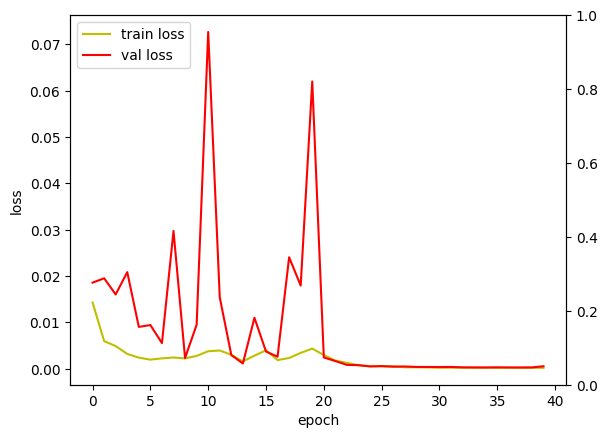

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
PATH = "/content/datasets/plate-box-14/test/"
t_f = open('/content/datasets/plate-box-14/test/_annotations.coco.json')
t_f = t_f.read()
test_json_object = json.loads(t_f)
show_data(test_json_object)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

In [ ]:
test_data = make_files_metadata(test_json_object)
y_test = make_y_points(test_json_object)
imgs = download_img(test_data)
x_test = imgs / 255
x_test = np.expand_dims(x_test,-1)
# test_data = make_files_metadata(json_object)
# imgs = download_img(test_data)

In [ ]:
x_test.shape

(76, 128, 256, 3, 1)

In [ ]:
o = model.predict(x_test)
o

3/3 [==============================] - 2s 307ms/step


array([[0.16152568, 0.01071435, 0.8752623 , 0.03983602, 0.14112124,
        0.45117196, 0.84492296, 0.5968165 ],
       [0.17904119, 0.4192346 , 0.82281387, 0.32416564, 0.1901712 ,
        0.68260044, 0.8325089 , 0.59116775],
       [0.14537548, 0.30962706, 0.84859633, 0.37774336, 0.14331344,
        0.65073866, 0.8457974 , 0.7226523 ],
       [0.16791703, 0.27287745, 0.86099595, 0.42812276, 0.1557065 ,
        0.594095  , 0.84502745, 0.74907035],
       [0.08965094, 0.29080874, 0.9050871 , 0.27943152, 0.09396036,
        0.7403685 , 0.9098148 , 0.7323726 ],
       [0.22640796, 0.24989708, 0.80370784, 0.26273486, 0.21484308,
        0.52524495, 0.7923646 , 0.5410266 ],
       [0.10533213, 0.37157127, 0.88625723, 0.25060582, 0.11995684,
        0.7610811 , 0.89858073, 0.6322357 ],
       [0.17963763, 0.1850287 , 0.8119025 , 0.24980082, 0.18525647,
        0.726474  , 0.8106603 , 0.7733015 ],
       [0.37686953, 0.03084299, 0.81416017, 0.08295391, 0.20899452,
        0.28055575, 0.653144

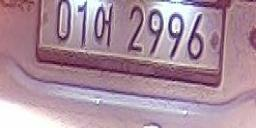

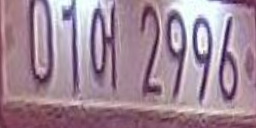

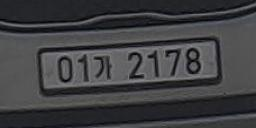

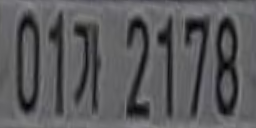

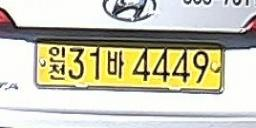

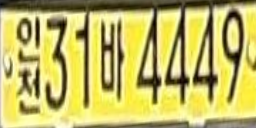

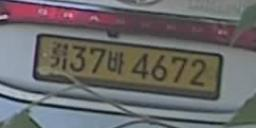

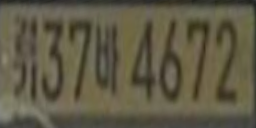

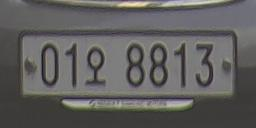

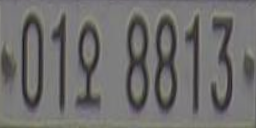

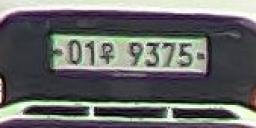

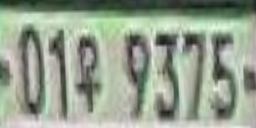

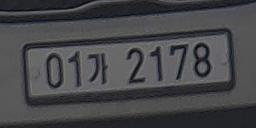

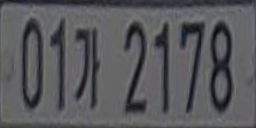

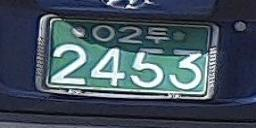

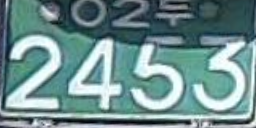

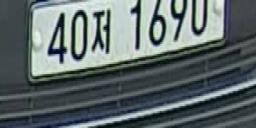

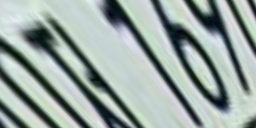

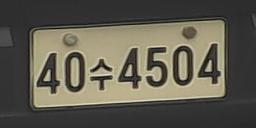

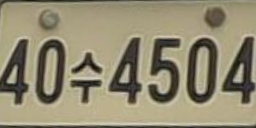

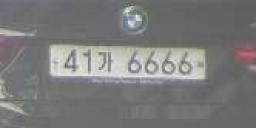

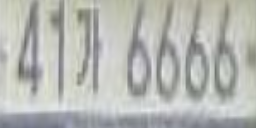

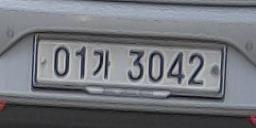

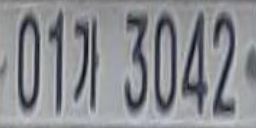

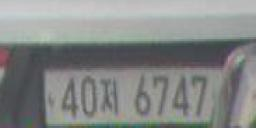

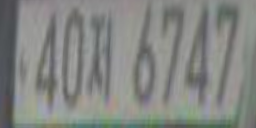

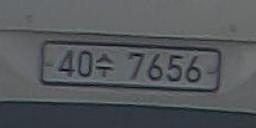

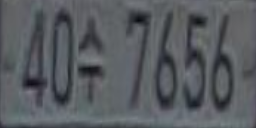

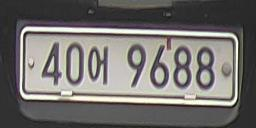

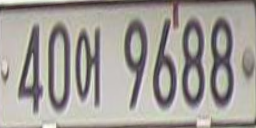

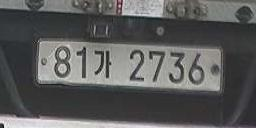

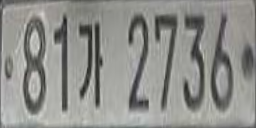

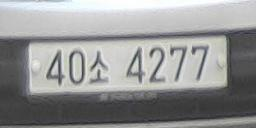

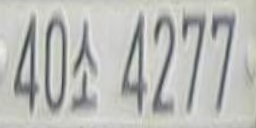

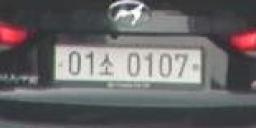

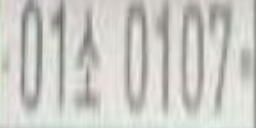

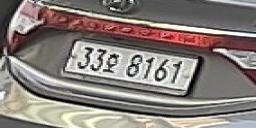

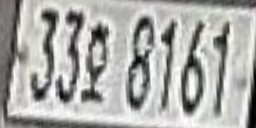

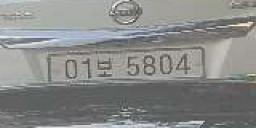

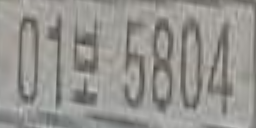

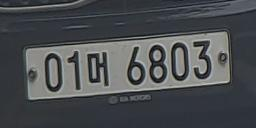

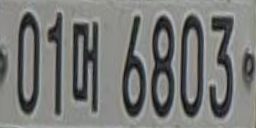

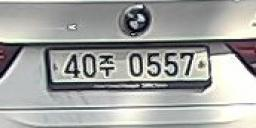

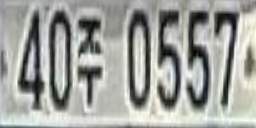

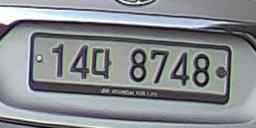

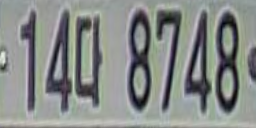

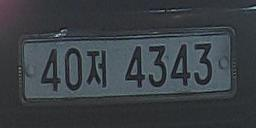

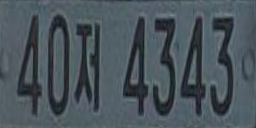

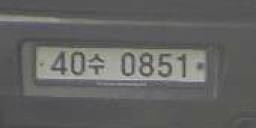

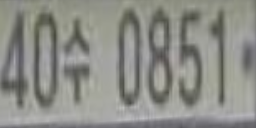

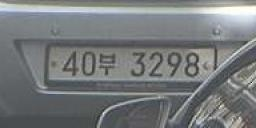

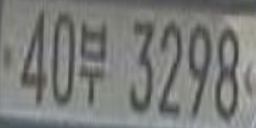

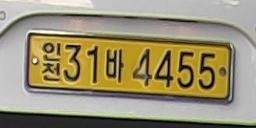

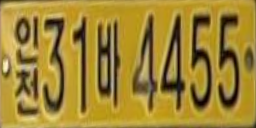

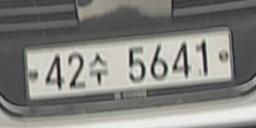

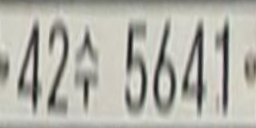

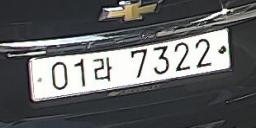

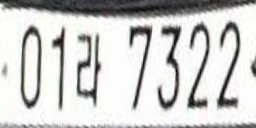

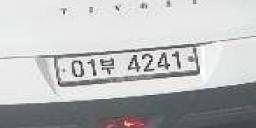

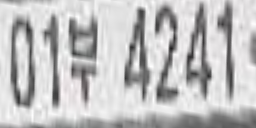

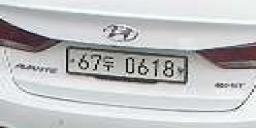

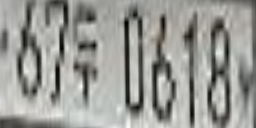

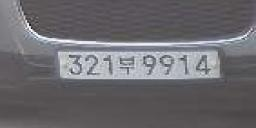

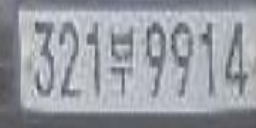

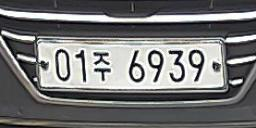

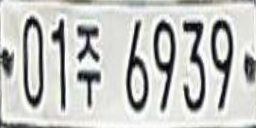

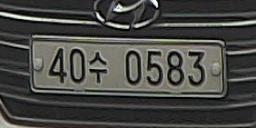

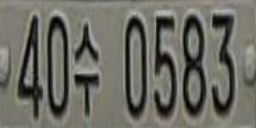

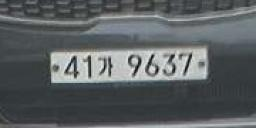

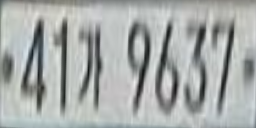

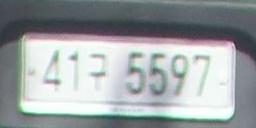

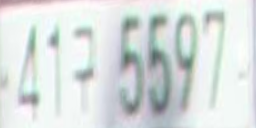

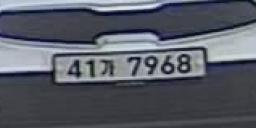

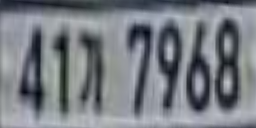

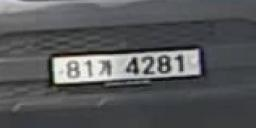

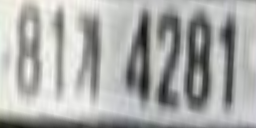

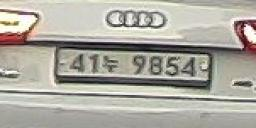

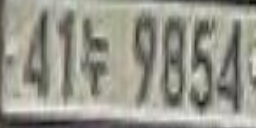

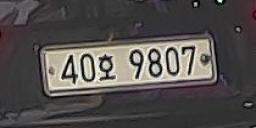

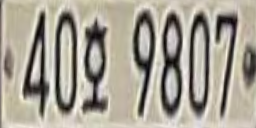

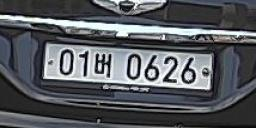

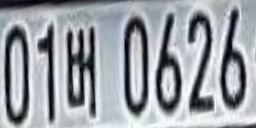

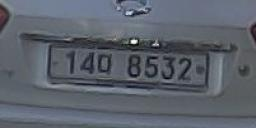

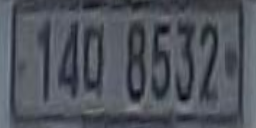

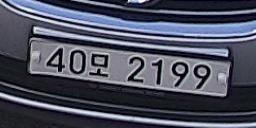

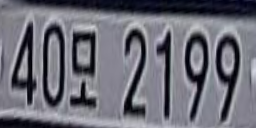

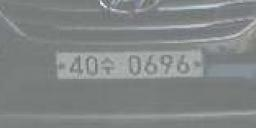

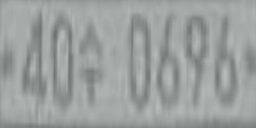

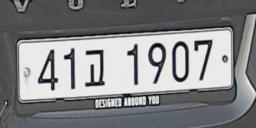

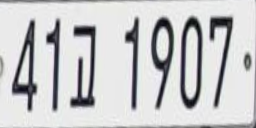

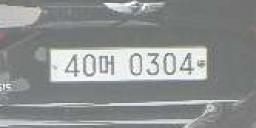

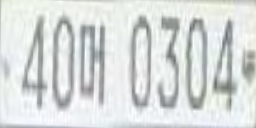

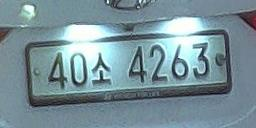

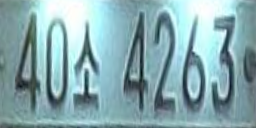

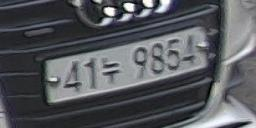

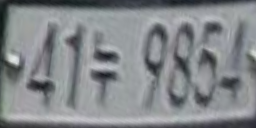

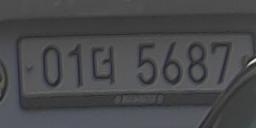

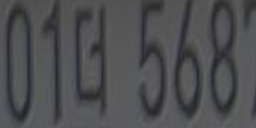

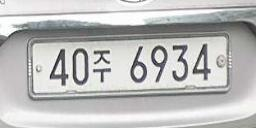

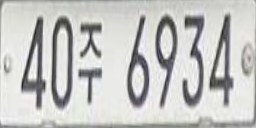

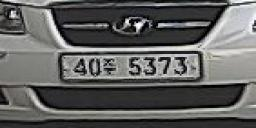

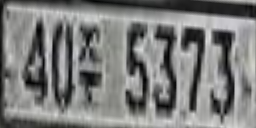

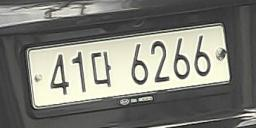

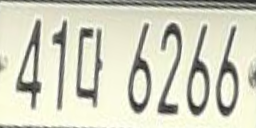

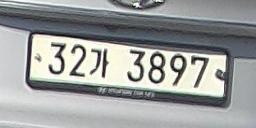

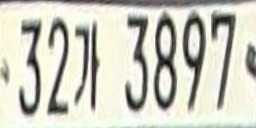

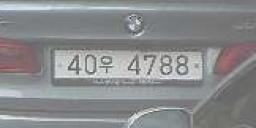

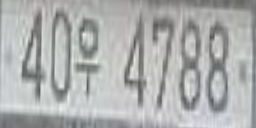

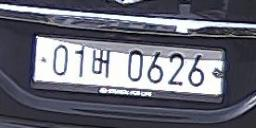

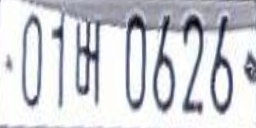

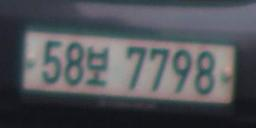

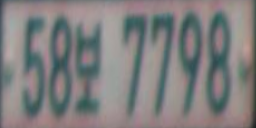

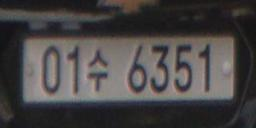

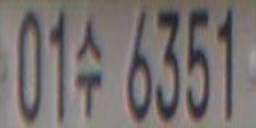

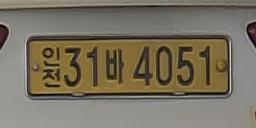

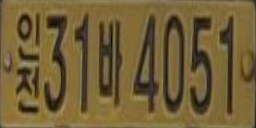

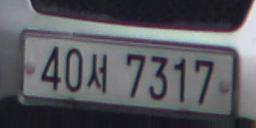

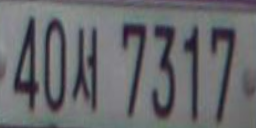

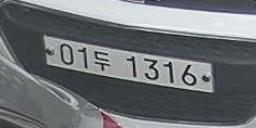

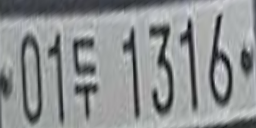

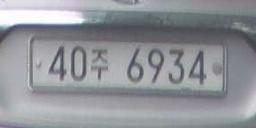

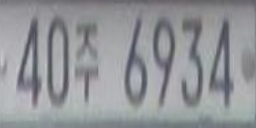

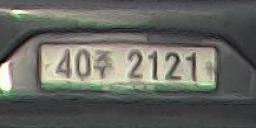

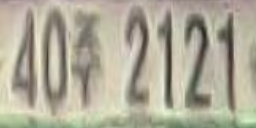

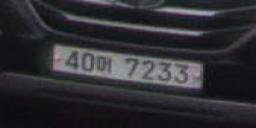

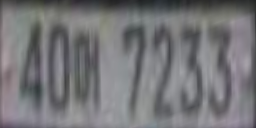

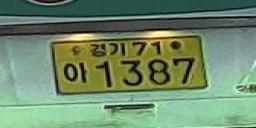

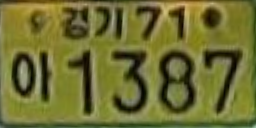

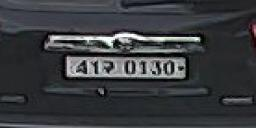

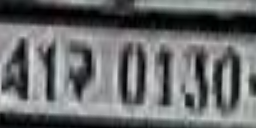

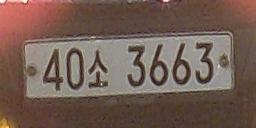

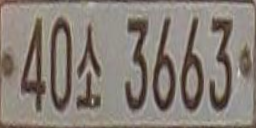

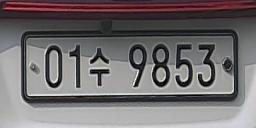

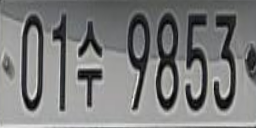

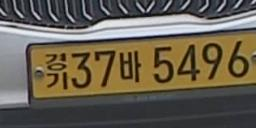

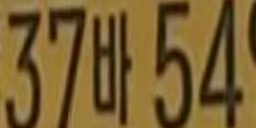

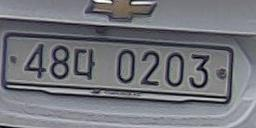

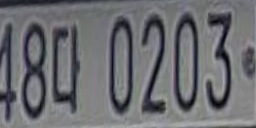

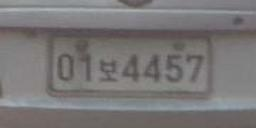

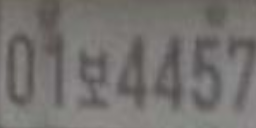

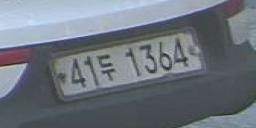

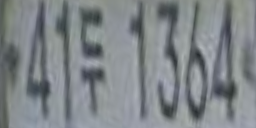

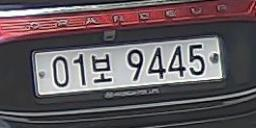

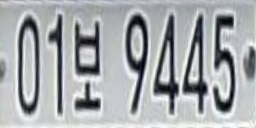

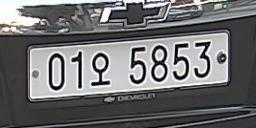

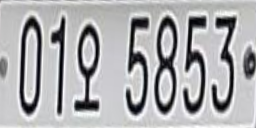

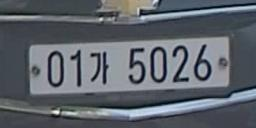

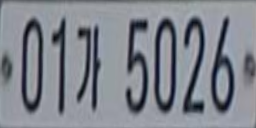

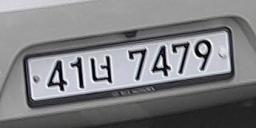

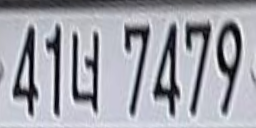

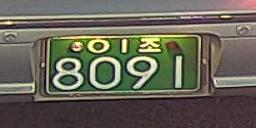

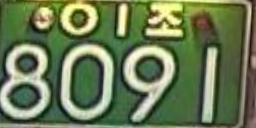

In [ ]:
for i in range(len(o)):
  test_result = x_test[i] * 256
  test_result = test_result.reshape(128, 256, 3)
  cols = 256
  row= 128
  arr = o[i]
  point = [[arr[0] * 256, arr[1] * 128], [arr[2] * 256, arr[3] * 128], [arr[4] * 256, arr[5] * 128], [arr[6] * 256, arr[7] * 128]]
  box = [[0, 0], [cols, 0], [0, row], [cols, row]]
  pts1 = np.float32(point)
  pts2 = np.float32(box)
  point = np.int32(point)
  # draw_circles_on_edges(test_result, point)
  M = cv2.getPerspectiveTransform(pts1, pts2)
  dst = cv2.warpPerspective(test_result, M, (cols, row))  # 변환후 크기 (x좌표, y좌표)
  cv2_imshow(test_result)
  cv2_imshow(dst)